# Can the OAE Efficiency Map support Direct Ocean Removal?
DOR creates a CO₂ deficit by removing carbon directly from the surface ocean and, like OAE, removes carbon from the atmosphere via air-sea gas exchange. 

Can the OAE efficiency data be recast to support DOR?

This notebook explore how to apply a chemistry-based conversion factor between OAE and dissolved CO₂ removal. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product

import numpy as np
import dask
import xarray as xr

import matplotlib.pyplot as plt

import box_model
import util

## Diagram effect of OAE & DOR in DIC v. Alk phase space


## Illustration

Set some typical values for ocean tracers at the surface

In [3]:
ocn_state = {
    "dic": 1958.72553055,  # mmol/m^3
    "alk": 2261.89,  # mmol/m^3
    "salt": 34.51,  #
    "temp": 24.37,  # °C
    "sio3": 4.23,  # mmol/m^3
    "po4": 0.12,  # mmol/m^3
}
ocn_state

{'dic': 1958.72553055,
 'alk': 2261.89,
 'salt': 34.51,
 'temp': 24.37,
 'sio3': 4.23,
 'po4': 0.12}

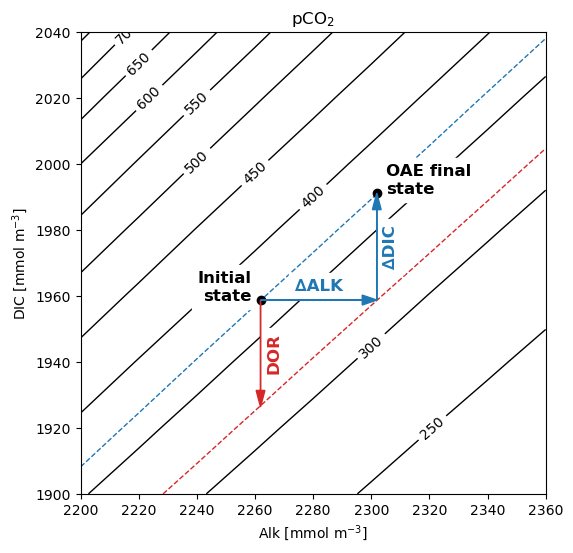

In [4]:
# compute C-sys over DIC-Alk phase space
dic_range = np.arange(1900, 2060, 20)
alk_range = np.arange(2200, 2380, 20)
ALK, DIC = np.meshgrid(alk_range, dic_range)
SSS = ocn_state["salt"] * np.ones(DIC.shape)
SST = ocn_state["temp"] * np.ones(DIC.shape)
csys_solver_space = box_model.calc_csys(DIC, ALK, SSS, SST)


# define an OAE perturbation
# set initial state
alk_start = ocn_state["alk"]
dic_start = ocn_state["dic"]

csys_solver_start = box_model.calc_csys(
    dic_start,
    alk_start,
    ocn_state["salt"],
    ocn_state["temp"],
)

# set alkalinity addition and compute end state
alk_end = alk_start + 40.0
dic_end = csys_solver_start.calc_new_dic_w_oae(alk_end)

csys_solver_end = box_model.calc_csys(
    dic_end, alk_end, ocn_state["salt"], ocn_state["temp"]
)
csys_solver_mid = box_model.calc_csys(
    dic_start, alk_end, ocn_state["salt"], ocn_state["temp"]
)

# determine equivalent DOR
dor_delta_dic = dic_end - dic_start


fig, ax = plt.subplots(figsize=(6, 6))
cs = ax.contour(
    ALK,
    DIC,
    csys_solver_space.pco2,
    levels=np.arange(200, 1250, 50),
    colors="k",
    linewidths=1.0,
)
ax.clabel(cs, cs.levels, inline=True, fontsize=10)

ax.contour(
    ALK,
    DIC,
    csys_solver_space.pco2,
    levels=[csys_solver_start.pco2],
    colors="tab:blue",
    linewidths=1.0,
    linestyles="--",
)

ax.contour(
    ALK,
    DIC,
    csys_solver_space.pco2,
    levels=[csys_solver_mid.pco2],
    colors="tab:red",
    linewidths=1.0,
    linestyles="--",
)


head_length = 5

# OAE
ax.plot(alk_start, dic_start, "ko", zorder=100)
ax.plot(alk_end, dic_end, "ko", zorder=100)

ax.arrow(
    alk_start,
    dic_start,
    alk_end - alk_start - head_length,
    0,
    head_width=3,
    head_length=head_length,
    color="tab:blue",
    zorder=1000,
)
ax.arrow(
    alk_end,
    dic_start,
    0,
    dic_end - dic_start - head_length,
    head_width=3,
    head_length=head_length,
    color="tab:blue",
    zorder=1000,
)

ax.text(
    np.mean([alk_start, alk_end]),
    dic_start + np.diff(ax.get_ylim()) * 0.02,
    "∆ALK",
    ha="center",
    fontsize=12,
    fontweight="bold",
    color="tab:blue",
    backgroundcolor="w",
    zorder=100,
)

ax.text(
    alk_end + np.diff(ax.get_xlim()) * 0.03,
    np.mean([dic_start, dic_end]),
    "∆DIC",
    ha="center",
    va="center",
    rotation=90,
    fontsize=12,
    fontweight="bold",
    color="tab:blue",
    backgroundcolor="w",
)

ax.text(
    alk_start - np.diff(ax.get_xlim()) * 0.02,
    dic_start,
    "Initial\nstate",
    ha="right",
    fontsize=12,
    fontweight="bold",
    backgroundcolor="w",
)

ax.text(
    alk_end + np.diff(ax.get_xlim()) * 0.02,
    dic_end,
    "OAE final\nstate",
    ha="left",
    fontsize=12,
    fontweight="bold",
    backgroundcolor="w",
)

ax.arrow(
    alk_start,
    dic_start,
    0,
    -(dor_delta_dic - head_length),
    head_width=3,
    head_length=head_length,
    color="tab:red",
    zorder=100,
)

ax.text(
    alk_start + np.diff(ax.get_xlim()) * 0.03,
    np.mean([dic_start, dic_start - (dic_end - dic_start)]),
    "DOR",
    ha="center",
    va="center",
    rotation=90,
    fontsize=12,
    fontweight="bold",
    color="tab:red",
    backgroundcolor="w",
)

ax.set_ylabel("DIC [mmol m$^{-3}$]")
ax.set_xlabel("Alk [mmol m$^{-3}$]")
ax.set_title("pCO$_2$");

## Box model calculations

<img src="data/simple-model.png" alt="box mode" width="400"/>

Features:
- Specified mixed layer depth 
- Full carbonate chemistry
- Two tracers: DIC, Alk
- Gas exchange computed from wind and atmospheric mixing ration (Χ<sub>CO₂</sub>)
- A dilution rate is specified using a timescale (τ) and tracer boundary conditions
- The model can be spun up so that the initial conditions yield a steady-state solution
- Perturbations to alkalinity (`dalk`) or DIC (`ddic`) can be supplied; these are applied at t = 0



### Compare carbonate system solver

[PyCO2SYS](https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/) is a community toolbox — but very slow. The model supports using `pyco2sys` as well as a much much fast implementation of the carbonate chemistry derived from code developed under the OCMIP (`ocmip`) protocols. These two approaches are different.

Here we integrate the model in both ways and show that they are different — though the CDR anomaly differences are small.

In [15]:
%%time
forcing = dict(
    h=100.0,  # m; mixed layer depth
    u10=7.0,  # m/s; wind speed at 10 m
    Xco2atm=425.0,  # csys_solver.pco2, # µatm; atmospheric CO2
)

bc = dict(dic_bc=2000.0, alk_bc=2250.0)

dic = ocn_state["dic"]
alk = ocn_state["alk"]

ocn_other_state = {k: v for k, v in ocn_state.items() if k not in ["dic", "alk"]}

nday = 365

model = box_model.mixed_layer(
    dic=dic,
    alk=alk,
    tau_dilution=0.0,
    **ocn_other_state,
    **forcing,
    **bc,
    csys_solver="ocmip",
)

ds_ocmip = model.run(nday, spinup=True, dalk=40.0, ddic=0.0)
ds_ocmip

CPU times: user 90.5 ms, sys: 0 ns, total: 90.5 ms
Wall time: 105 ms


<xarray.Dataset> Size: 20kB
Dimensions:           (time: 366)
Coordinates:
  * time              (time) int64 3kB 0 1 2 3 4 5 6 ... 360 361 362 363 364 365
Data variables:
    dic               (time) float64 3kB 1.977e+03 1.977e+03 ... 2.009e+03
    alk               (time) float64 3kB 2.288e+03 2.288e+03 ... 2.288e+03
    pco2              (time) float64 3kB 362.3 363.4 364.5 ... 425.0 425.0 425.0
    fgco2             (time) float64 3kB 0.622 0.6114 ... 0.0003546 0.0003472
    dilution_dic      (time) float64 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fgco2_cumulative  (time) float64 3kB 0.0622 0.1233 0.1834 ... 3.294 3.294

In [12]:
%%time

model = box_model.mixed_layer(
    dic=dic,
    alk=alk,
    tau_dilution=0.0,
    **ocn_other_state,
    **forcing,
    **bc,
    csys_solver="pyco2sys",
)

ds_pyco2sys = model.run(nday, spinup=True, dalk=40.0, ddic=0.0)
ds_pyco2sys

CPU times: user 19.8 s, sys: 44.7 ms, total: 19.9 s
Wall time: 23.8 s


<xarray.Dataset> Size: 20kB
Dimensions:           (time: 366)
Coordinates:
  * time              (time) int64 3kB 0 1 2 3 4 5 6 ... 360 361 362 363 364 365
Data variables:
    dic               (time) float64 3kB 1.98e+03 1.981e+03 ... 2.013e+03
    alk               (time) float64 3kB 2.285e+03 2.285e+03 ... 2.285e+03
    pco2              (time) float64 3kB 361.5 362.7 363.8 ... 425.0 425.0 425.0
    fgco2             (time) float64 3kB 0.6513 0.6397 ... 0.0002625 0.0002568
    dilution_dic      (time) float64 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fgco2_cumulative  (time) float64 3kB 0.06513 0.1291 0.1919 ... 3.307 3.307

Plot the results from the two integrations

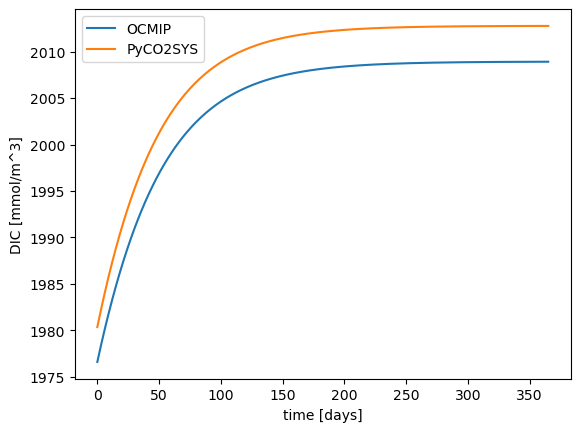

In [13]:
ds_ocmip.dic.plot(label="OCMIP")
ds_pyco2sys.dic.plot(label="PyCO2SYS")
plt.legend();

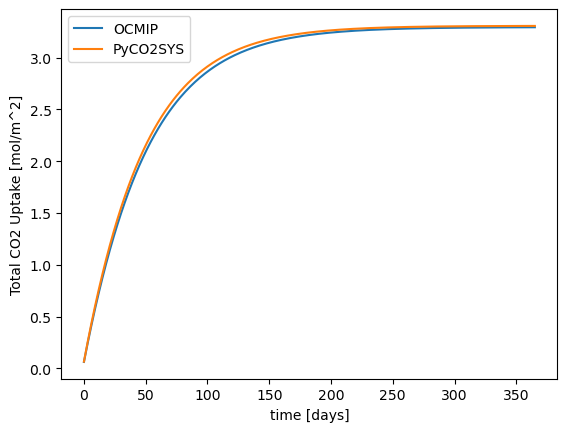

In [14]:
ds_ocmip.fgco2_cumulative.plot(label="OCMIP")
ds_pyco2sys.fgco2_cumulative.plot(label="PyCO2SYS")
plt.legend();

## Explore OAE v DOR

Explore a range of `dalk` and dilution rates over the DIC v Alk phase space. 

We conduct a control, OAE, and DOR model integration at each point in the phase space, then save the results as [Xarray](https://docs.xarray.dev/en/stable/) datasets.

We're using [dask](https://www.dask.org/) for parallelism, wrapping the model in a `dask.delayed` function.


Steps:
1. Spin up a `dask` cluster
2. For each value of `dalk`, compute an equivalent `ddic` (one objective is to demonstrate that we can do this correctly)
3. Generate a dictionary of `dask.delayed` objects comprising all the model runs
4. Compute
5. Save the results as Xarray datasets



In [17]:
cluster, client = util.get_ClusterClient(memory="2GB")
cluster.scale(128)
client

/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.103:42631,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [18]:
%%time
# define the phase space of our calculation
coords = dict(
    dic_base=np.arange(1900, 2060, 20),  # mmol/m^3
    alk_base=np.arange(2200, 2380, 20),  # mmol/m^3
    dalk=np.array([10.0, 20.0, 50.0, 100.0, 200.0, 500.0]),  # mmol/m^3
    tau_dilution=np.array([0.0, 10.0, 50.0, 100.0]),  # days (zero implies no dilution)
)

# set forcing and state
forcing = dict(
    h=100.0,  # m; mixed layer depth
    u10=7.0,  # m/s; wind speed at 10 m
    Xco2atm=425.0,  # csys_solver.pco2, # µatm; atmospheric CO2
)
ocn_other_state = {k: v for k, v in ocn_state.items() if k not in ["dic", "alk"]}


@dask.delayed
def wrapper(dic, alk, coords_here, tau_dilution=0.0, dalk=0.0, ddic=0.0):
    """return a dask.delayed instance of an Xarray dataset comprising
    the result of a box model integration.
    """
    model = box_model.mixed_layer(
        dic=dic, alk=alk, tau_dilution=tau_dilution, **ocn_other_state, **forcing, **bc
    )
    ds = (
        model.run(nday, spinup=True, dalk=dalk, ddic=ddic)
        .assign_coords(coords_here)
        .expand_dims("dic_base", axis=1)
        .expand_dims("alk_base", axis=2)
        .expand_dims("dalk", axis=3)
        .expand_dims("tau_dilution", axis=4)
    )
    ds["ddic"] = xr.full_like(ds.dalk, fill_value=np.nan)
    ds.ddic[:] = ddic
    return ds


# specify the duration of the model runs
nday = 365 * 5

# loop over the phase space and generate delayed objects
dss = dict(ctrl=[], oae=[], dor=[])
ddic_list = []
for dic, alk in product(coords["dic_base"], coords["alk_base"]):
    for dalk in coords["dalk"]:
        csys_solver = box_model.calc_csys(dic=dic, alk=alk, **ocn_other_state)
        ddic = dic - csys_solver.calc_new_dic_w_oae(alk + dalk)
        bc = dict(dic_bc=dic, alk_bc=alk)

        for tau_dilution in coords["tau_dilution"]:
            coords_here = {
                "dic_base": dic,
                "alk_base": alk,
                "dalk": dalk,
                "tau_dilution": tau_dilution,
            }

            dss["ctrl"].append(wrapper(dic, alk, coords_here, tau_dilution))
            dss["oae"].append(wrapper(dic, alk, coords_here, tau_dilution, dalk=dalk))
            dss["dor"].append(wrapper(dic, alk, coords_here, tau_dilution, ddic=ddic))

# compute!
dss = dask.compute(dss)[0]

# assemble datasets
ds_ctrl = xr.combine_by_coords(dss["ctrl"])
ds_oae = xr.combine_by_coords(dss["oae"])
ds_dor = xr.combine_by_coords(dss["dor"])
ds_ctrl

CPU times: user 32.5 s, sys: 2.15 s, total: 34.7 s
Wall time: 1min 42s


<xarray.Dataset> Size: 151MB
Dimensions:           (time: 1826, dic_base: 8, alk_base: 9, dalk: 6,
                       tau_dilution: 4)
Coordinates:
  * time              (time) int64 15kB 0 1 2 3 4 5 ... 1821 1822 1823 1824 1825
  * dic_base          (dic_base) int64 64B 1900 1920 1940 ... 2000 2020 2040
  * alk_base          (alk_base) int64 72B 2200 2220 2240 ... 2320 2340 2360
  * dalk              (dalk) float64 48B 10.0 20.0 50.0 100.0 200.0 500.0
  * tau_dilution      (tau_dilution) float64 32B 0.0 10.0 50.0 100.0
Data variables:
    dic               (time, dic_base, alk_base, dalk, tau_dilution) float64 25MB ...
    alk               (time, dic_base, alk_base, dalk, tau_dilution) float64 25MB ...
    pco2              (time, dic_base, alk_base, dalk, tau_dilution) float64 25MB ...
    fgco2             (time, dic_base, alk_base, dalk, tau_dilution) float64 25MB ...
    dilution_dic      (time, dic_base, alk_base, dalk, tau_dilution) float64 25MB ...
    fgco2_cumulative  (time, dic_base, alk_base, dalk, tau_dilution) float64 25MB ...
    ddic              (tau_dilution, alk_base, dic_base, dalk) float64 14kB 0...

### Control run

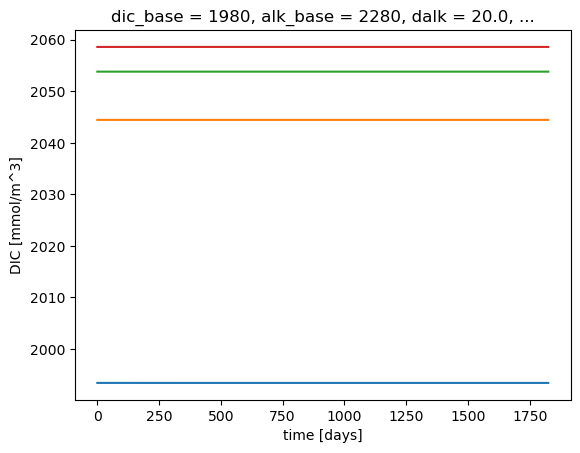

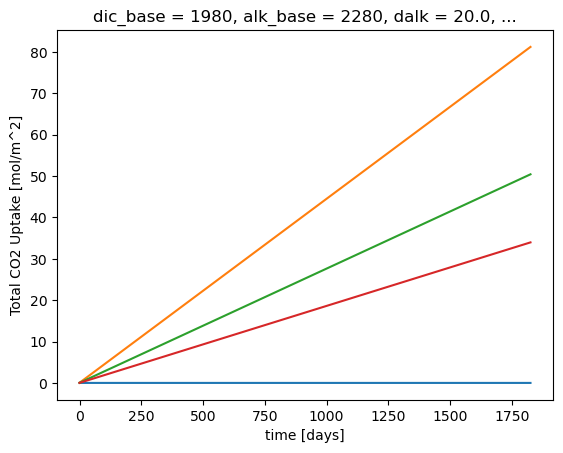

In [32]:
isel = dict(dic_base=4, alk_base=4, dalk=1)

plt.figure()
for tau in ds_ctrl.tau_dilution.values:
    (ds_ctrl).dic.isel(isel).sel(tau_dilution=tau).plot(label=f"{tau}")


plt.figure()
for tau in ds_ctrl.tau_dilution.values:
    (ds_ctrl).fgco2_cumulative.isel(isel).sel(tau_dilution=tau).plot(label=f"{tau}")

### CDR Effects: no dilution

In this case, we would expect our DOR run to exactly match the OAE run. Does it?

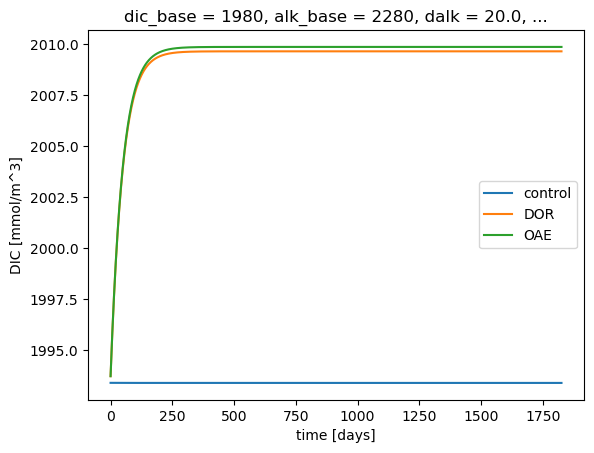

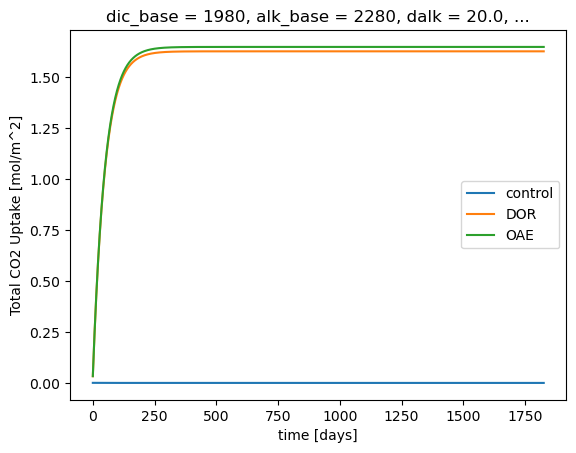

In [33]:
isel = dict(dic_base=4, alk_base=4, dalk=1, tau_dilution=0)

plt.figure()
(ds_ctrl).dic.isel(isel).plot(label="control")
(ds_dor - ds_dor.ddic).dic.isel(isel).plot(
    label="DOR"
)  # add back the DIC that was removed
(ds_oae).dic.isel(isel).plot(label="OAE")

plt.legend()

plt.figure()
(ds_ctrl).fgco2_cumulative.isel(isel).plot(label="control")
(ds_dor).fgco2_cumulative.isel(isel).plot(label="DOR")
(ds_oae).fgco2_cumulative.isel(isel).plot(label="OAE")
plt.legend();

### CDR Effects: with dilution

In this case, we have to remove the CO2 uptake from the control to look at the CDR effect.

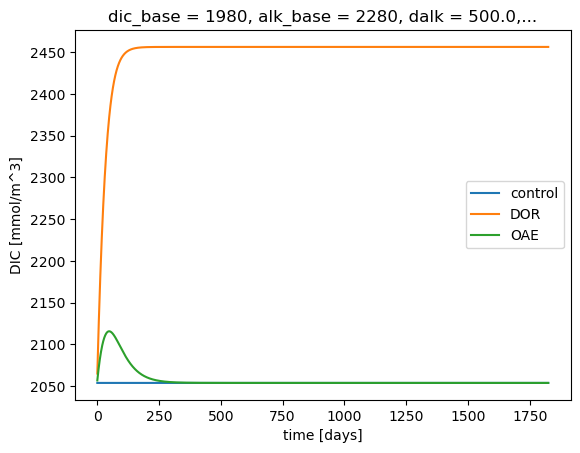

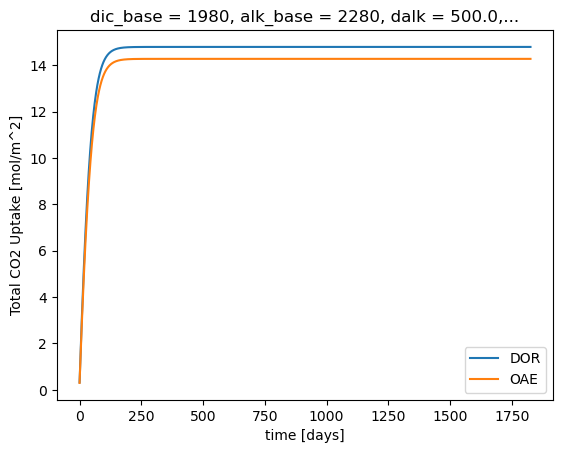

In [34]:
isel = dict(dic_base=4, alk_base=4, dalk=-1, tau_dilution=2)

plt.figure()
(ds_ctrl).dic.isel(isel).plot(label="control")
(ds_dor - ds_dor.ddic).dic.isel(isel).plot(
    label="DOR"
)  # add back the DIC that was removed
(ds_oae).dic.isel(isel).plot(label="OAE")

plt.legend()

plt.figure()
with xr.set_options(keep_attrs=True):
    (ds_dor - ds_ctrl.fgco2_cumulative).fgco2_cumulative.isel(isel).plot(label="DOR")
    (ds_oae - ds_ctrl.fgco2_cumulative).fgco2_cumulative.isel(isel).plot(label="OAE")
plt.legend();

### Phase space plots

Construct dataset of difference between OAE and DOR

In [35]:
with xr.set_options(keep_attrs=True):
    ds_oae_m_dor = ds_oae - ds_dor

ds_oae_m_dor

<xarray.Dataset> Size: 151MB
Dimensions:           (time: 1826, dic_base: 8, alk_base: 9, dalk: 6,
                       tau_dilution: 4)
Coordinates:
  * time              (time) int64 15kB 0 1 2 3 4 5 ... 1821 1822 1823 1824 1825
  * dic_base          (dic_base) int64 64B 1900 1920 1940 ... 2000 2020 2040
  * alk_base          (alk_base) int64 72B 2200 2220 2240 ... 2320 2340 2360
  * dalk              (dalk) float64 48B 10.0 20.0 50.0 100.0 200.0 500.0
  * tau_dilution      (tau_dilution) float64 32B 0.0 10.0 50.0 100.0
Data variables:
    dic               (time, dic_base, alk_base, dalk, tau_dilution) float64 25MB ...
    alk               (time, dic_base, alk_base, dalk, tau_dilution) float64 25MB ...
    pco2              (time, dic_base, alk_base, dalk, tau_dilution) float64 25MB ...
    fgco2             (time, dic_base, alk_base, dalk, tau_dilution) float64 25MB ...
    dilution_dic      (time, dic_base, alk_base, dalk, tau_dilution) float64 25MB ...
    fgco2_cumulative  (time, dic_base, alk_base, dalk, tau_dilution) float64 25MB ...
    ddic              (tau_dilution, alk_base, dic_base, dalk) float64 14kB 8...

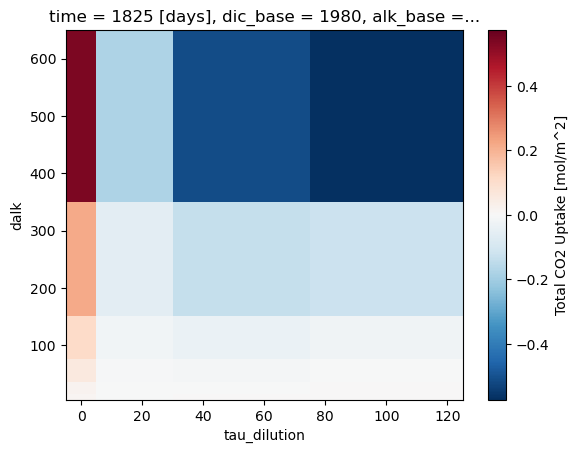

In [36]:
isel = dict(dic_base=4, alk_base=4)
ds_oae_m_dor.fgco2_cumulative.isel(time=-1, **isel).plot()

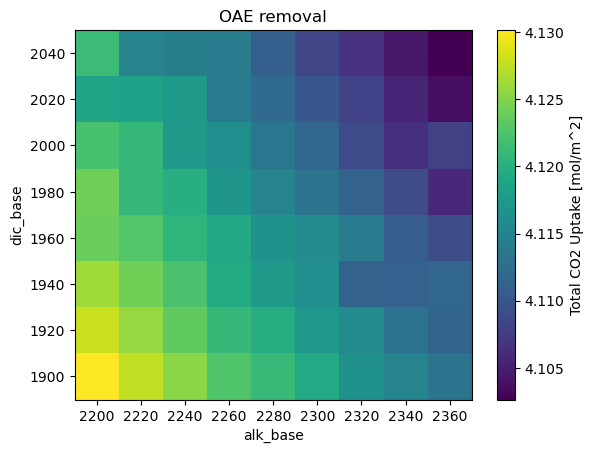

In [40]:
isel = dict(dalk=2, tau_dilution=0, time=-1)  # dic_base=5, alk_base=2)
with xr.set_options(keep_attrs=True):
    (ds_oae - ds_ctrl).fgco2_cumulative.isel(**isel).plot()

plt.title("OAE removal");

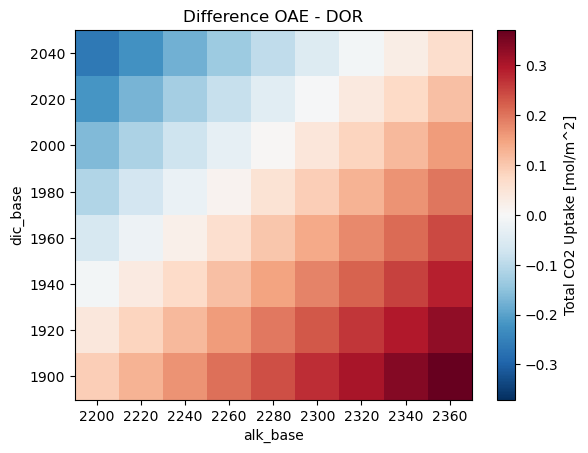

In [38]:
isel = dict(dalk=2, tau_dilution=0, time=-1)
ds_oae_m_dor.fgco2_cumulative.isel(**isel).plot()
plt.title("Difference OAE - DOR");